# Ensemble Assesment - Boosting and Gradient Boosting

---
## Import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostRegressor, GradientBoostingRegressor
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import RandomForestClassifier

# others
from mltools import classification_tools as CT
from mltools import model_tools as MT

---
## Load data and split into train and test sets
Data is loaded from the processed data file and split into train and test sets. The train set is used to train the model and the test set is used to evaluate the model.

In [2]:
# Load data
file_path = 'data/input.csv'
df = pd.read_csv(file_path)
df.head(10)

,MES_x,DIA_x,HOUR,IRRAD_VALUE,UTIL_VALUE,dia_mes
0,1,1,0,0.0,0.000023,1
1,1,2,0,0.0,0.000012,2
2,1,3,0,0.0,0.000008,3
3,1,4,0,0.0,0.000008,4
4,1,5,0,0.0,0.000008,5
5,1,6,0,0.0,0.000012,6
6,1,7,0,0.0,0.000000,7
7,1,8,0,0.0,0.000000,8
8,1,9,0,0.0,0.000004,9
9,1,10,0,0.0,0.000000,10


In [3]:
## Split the dataset into training and test sets

# Define input and output matrices
INPUTS = df.columns[~df.columns.isin(['UTIL_VALUE'])]
OUTPUT = 'UTIL_VALUE'

# Split
X_train, X_test, y_train, y_test = train_test_split(df[INPUTS], df[OUTPUT],
                                                    test_size=0.2, # percentage of test data
                                                    random_state=0) # seed for replication

# Check the shape of the resulting dataframes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14028, 5), y_train shape: (14028,)
X_test shape: (3508, 5), y_test shape: (3508,)


---
## AdaBoost
AdaBoost is a boosting algorithm that combines multiple weak learners to create a strong learner. The weak learners are trained sequentially and each weak learner tries to correct the mistakes made by the previous weak learners. The final model is a weighted sum of the weak learners.

In [4]:
## Fit an AdaBoost model
n_estimators = 5000
max_depth = 4
min_impurity_decrease = 0.0001
model_ab = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth,
                                                    min_impurity_decrease=min_impurity_decrease), 
                                                    n_estimators=n_estimators,
                                                    random_state=999)

model_ab.fit(X_train, y_train)
model_ab.get_params()

{'base_estimator': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': 4,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0001,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeRegressor(max_depth=4, min_impurity_decrease=0.0001),
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 5000,
 'random_state': 999}

In [9]:
## Predict
y_train_pred_ab = model_ab.predict(X_train)
y_test_pred_ab = model_ab.predict(X_test)

In [12]:
## Evaluate

# Mean Squared Error
mse_train_ab = metrics.mean_squared_error(y_train, y_train_pred_ab)
mse_test_ab = metrics.mean_squared_error(y_test, y_test_pred_ab)

# Root Mean Squared Error
rmse_train_ab = np.sqrt(mse_train_ab)
rmse_test_ab = np.sqrt(mse_test_ab)

# R2
r2_train_ab = metrics.r2_score(y_train, y_train_pred_ab)
r2_test_ab = metrics.r2_score(y_test, y_test_pred_ab)

# Mean Absolute Error
mae_train_ab = metrics.mean_absolute_error(y_train, y_train_pred_ab)
mae_test_ab = metrics.mean_absolute_error(y_test, y_test_pred_ab)

# Dataframe with results
results_ab = pd.DataFrame({'Metric': ['MSE', 'RMSE', 'R2', 'MAE'],
                        'Train': [mse_train_ab, rmse_train_ab, r2_train_ab, mae_train_ab],
                        'Test': [mse_test_ab, rmse_test_ab, r2_test_ab, mae_test_ab]})
results_ab

,Metric,Train,Test
0,MSE,0.006034,0.006456
1,RMSE,0.077677,0.080348
2,R2,0.899025,0.894149
3,MAE,0.051271,0.053028


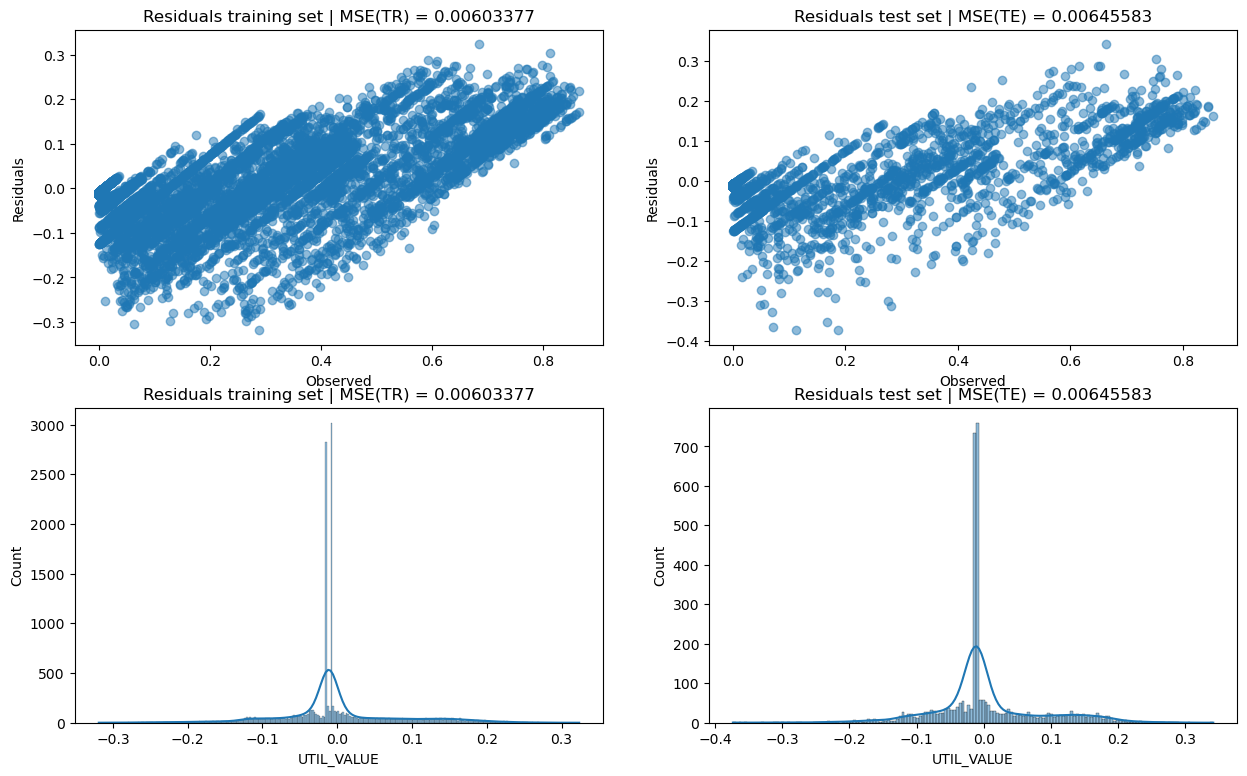

In [16]:
## Plot residuals (scatter and histogram)
plt.figure(figsize=(15, 9))

# Calculate residuals
residuals_train_ab = y_train - y_train_pred_ab
residuals_test_ab = y_test - y_test_pred_ab

# Scatter plots
plt.subplot(2, 2, 1)
plt.scatter(y_train, residuals_train_ab, alpha=0.5)
plt.title(f'Residuals training set | MSE(TR) = {mse_train_ab:.8f}')
plt.xlabel('Observed')
plt.ylabel('Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_test, residuals_test_ab, alpha=0.5)
plt.title(f'Residuals test set | MSE(TE) = {mse_test_ab:.8f}')
plt.xlabel('Observed')
plt.ylabel('Residuals')

# Histograms
plt.subplot(2, 2, 3)
sns.histplot(residuals_train_ab, kde=True)
plt.title(f'Residuals training set | MSE(TR) = {mse_train_ab:.8f}')

plt.subplot(2, 2, 4)
sns.histplot(residuals_test_ab, kde=True)
plt.title(f'Residuals test set | MSE(TE) = {mse_test_ab:.8f}')
plt.show()